## Beispiel für nichtlineares Randwertproblem

$$\begin{split}-u''(x) + u(x)^3 & = -3+\frac{1}{8}(4-7 x+3 x^2)^3\\
u(0) & = 2\\
u(2) & = 1\end{split}$$

Die exakte Lösung ist gegeben durch

$$u_{\text{exact}} = \frac{1}{2} (4-7 x+3 x^2).$$

Python Import

In [1]:
from netgen.meshing import *
from netgen.csg import *
import netgen
from ngsolve import *

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

1D Mesh erstellen: (2 Elemente mit Intervall Länge 2)

In [2]:
# generate a 1D mesh
ngmesh = netgen.meshing.Mesh()
ngmesh.dim = 1

nel = 1
l0 = 2

pnums = []
for i in range(0, nel+1):
    pnums.append (ngmesh.Add (MeshPoint (Pnt(i/nel*l0, 0, 0))))

for i in range(0,nel):
    ngmesh.Add (Element1D ([pnums[i],pnums[i+1]], index=1))

ngmesh.Add (Element0D (pnums[0], index=1))
ngmesh.Add (Element0D (pnums[nel], index=2))

mesh = Mesh(ngmesh)

FE-Space und Trial, Test Proxyfunktionen für die Definition der schwachen Gleichung

In [3]:
order = 2
V = H1(mesh, order=order, dirichlet=[1,2])

u = V.TrialFunction()
v = V.TestFunction()

Durch partielle Integration des ersten Terms und für $v\in V=H_0^1([0,2])$ gilt
$$\underbrace{\int_0^2u'(x) v'(x) + u(x)^3 v(x) dx}_{=: A(u)}\ =\ \underbrace{\int_0^2 -3+\frac{1}{8}(4-7 x+3 x^2)^3 dx}_{=: f} \quad \forall v \in V$$

In [4]:
a = BilinearForm(V)
a += SymbolicBFI(grad(u)*grad(v)+u*u*u*v)

In [5]:
f = LinearForm(V)
f += SymbolicLFI((-3+1/8*(4-7*x+3*x*x)*(4-7*x+3*x*x)*(4-7*x+3*x*x))*v)
f.Assemble()

Im Folgenden ist $u$ der Lösungsvektor des Problems:

In [6]:
gfu = GridFunction(V)

Die Dirichlet Randbedingung wird für den Lösungsvektor gesetzt

In [7]:
u0 = CoefficientFunction([2,1])
gfu.Set(u0,BND)

Mit Hilfe der Newton Iteration wird das System gelöst.

$$F(u) = A(u) -f$$

* Newton Iteration
    * $res = A(u_n) - f$
    * $F'(u_n)\cdot \delta u = res$
    * $u_{n+1} = u_n - \delta u$


In [8]:
res = gfu.vec.CreateVector()
du  = gfu.vec.CreateVector()

for it in range(10):
    print ("Newton iteration", it)

    # solve linearized problem:
    # F(u_n)
    a.Apply (gfu.vec, res)
    res.data -= f.vec
    # F'(u_n)
    a.AssembleLinearization(gfu.vec)
    inv = a.mat.Inverse(V.FreeDofs())
    # F'(u_n) du = F(u_n)
    du.data = inv * res


    # update iteration
    # u_n+1 = u_n - du
    gfu.vec.data -= du

    #stopping criteria
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}^0.5 = ", stopcritval)
    if stopcritval < 1e-13:
        break

Newton iteration 0
<A u 0 , A u 0 >_{-1}^0.5 =  2.63044945649285
Newton iteration 1
<A u 1 , A u 1 >_{-1}^0.5 =  1.1461868091843586
Newton iteration 2
<A u 2 , A u 2 >_{-1}^0.5 =  0.23956338535903185
Newton iteration 3
<A u 3 , A u 3 >_{-1}^0.5 =  0.004330380345703539
Newton iteration 4
<A u 4 , A u 4 >_{-1}^0.5 =  6.498623280754964e-07
Newton iteration 5
<A u 5 , A u 5 >_{-1}^0.5 =  1.469602015585601e-14


In [9]:
def uexact(x):
    return 0.5*(4-7*x+3*x*x)

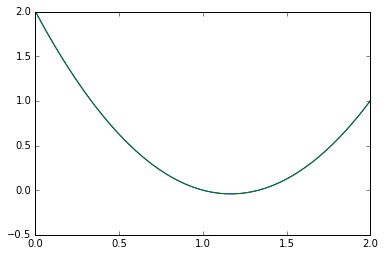

In [10]:
xi = np.linspace(0,l0,150)
ui = [gfu(xip) for xip in xi]

plt.plot(xi,ui)
plt.plot(xi,uexact(xi))

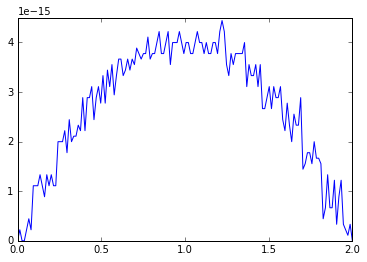

In [11]:
plt.plot(xi,np.abs(ui-uexact(xi)))

# Aufgaben


- Diskutiere die Konvergenz für $h \to 0$ für $p = 1,2,3$.
- Wie würde der `SymbolicEnergy` zum Problem Integrator lauten?

## Lösungen
### Konvergenz für $h\to 0$

Für die Diskussion der Konvergenz wird eine python Funktion definiert, welche die numerische Lösung abhängig von $h$ liefert. Der besseren Lesbarkeit halber als erstes das Erzeugen eines Rechennetzes in einer eigenen python Funktion definiert.

In [12]:
def buildMesh(numberOfElement = 1):
    # generate a 1D mesh
    ngmesh = netgen.meshing.Mesh()
    ngmesh.dim = 1

    nel = numberOfElement
    l0 = 2

    pnums = []
    for i in range(0, nel+1):
        pnums.append (ngmesh.Add (MeshPoint (Pnt(i/nel*l0, 0, 0))))

    for i in range(0,nel):
        ngmesh.Add (Element1D ([pnums[i],pnums[i+1]], index=1))

    ngmesh.Add (Element0D (pnums[0], index=1))
    ngmesh.Add (Element0D (pnums[nel], index=2))

    mesh = Mesh(ngmesh)
    return mesh

In [13]:
def compSolution(mesh, order = 2):
    V = H1(mesh, order=order, dirichlet=[1,2])

    u = V.TrialFunction()
    v = V.TestFunction()
    
    # def BilinearForm
    a = BilinearForm(V)
    a += SymbolicBFI(grad(u)*grad(v)+u*u*u*v)
    
    # def LinearForm
    f = LinearForm(V)
    f += SymbolicLFI((-3+1/8*(4-7*x+3*x*x)*(4-7*x+3*x*x)*(4-7*x+3*x*x))*v)
    f.Assemble()
    
    # solution vector
    gfu = GridFunction(V)
    
    # init Dirichlet BND-Condition
    u0 = CoefficientFunction([2,1])
    gfu.Set(u0,BND)
    
    # comp solution with Newton-Iteration
    res = gfu.vec.CreateVector()
    du  = gfu.vec.CreateVector()

    for it in range(10):
#        print ("Newton iteration", it)

        # solve linearized problem:
        # F(u_n)
        a.Apply (gfu.vec, res)
        res.data -= f.vec
        # F'(u_n)
        a.AssembleLinearization(gfu.vec)
        inv = a.mat.Inverse(V.FreeDofs())
        # F'(u_n) du = F(u_n)
        du.data = inv * res


        # update iteration
        # u_n+1 = u_n - du
        gfu.vec.data -= du

        #stopping criteria
        stopcritval = sqrt(abs(InnerProduct(du,res)))
#        print ("<A u",it,", A u",it,">_{-1}^0.5 = ", stopcritval)
        if stopcritval < 1e-13:
            break

    return gfu

Test der Funktionen

In [14]:
meshtest = buildMesh()

In [15]:
gfutest = compSolution(meshtest)

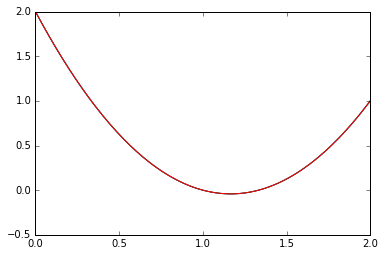

In [16]:
xi = np.linspace(0,l0,150)
gfui = [gfutest(xip) for xip in xi]

plt.plot(xi,ui)
plt.plot(xi,gfui)
plt.plot(xi,uexact(xi))

Die Resultate passen überein, womit die eigentlich Konvergenzanalyse durchgeführt werden kann:

In [17]:
nels = np.int64(10**np.linspace(1,4,10))
ps = range(1,5)

In [18]:
err = []
for nel in nels:
    d = []
    tempmesh = buildMesh(numberOfElement=nel)
    for p in ps:
        gfuvar = compSolution(mesh = tempmesh, order=p)
        diff = gfuvar - uexact(x)
        d.append(Integrate(diff,tempmesh))
    err.append(np.array(d))

err = np.array(err).T

Visualisierung mit `pyplot`

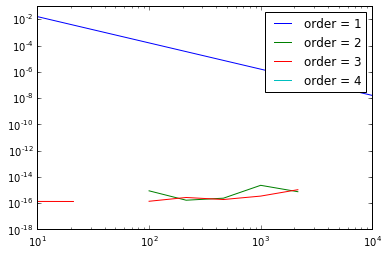

In [19]:
for (p, e) in zip(ps,err):
    plt.loglog(nels,e,label='order = '+str(p))
plt.legend()

**Was passiert hier?** $\Rightarrow$ Lösung ist ein Polynom von Grad 2, daher erhält man für Elemente zweiten Grades die numerisch exakte Lösung.

### Lösung mit SymbolicEnergy

In [20]:
u = V.TrialFunction()

# def BilinearForm
a2 = BilinearForm(V)
a2 += SymbolicEnergy(1/2*grad(u)*grad(u)+1/4*u*u*u*u-(-3+1/8*(4-7*x+3*x*x)*(4-7*x+3*x*x)*(4-7*x+3*x*x))*u)

In [21]:
gfue = GridFunction(V)
gfue.Set(u0,BND)

In [22]:
for it in range(10):
    print ("Newton iteration", it)

    # solve linearized problem:
    # F(u_n)
    a2.Apply (gfue.vec, res)
    # F'(u_n)
    a2.AssembleLinearization(gfue.vec)
    inv = a2.mat.Inverse(V.FreeDofs())
    # F'(u_n) du = F(u_n)
    du.data = inv * res


    # update iteration
    # u_n+1 = u_n - du
    gfue.vec.data -= du

    #stopping criteria
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}^0.5 = ", stopcritval)
    if stopcritval < 1e-13:
        break

Newton iteration 0
<A u 0 , A u 0 >_{-1}^0.5 =  2.63044945649285
Newton iteration 1
<A u 1 , A u 1 >_{-1}^0.5 =  1.1461868091843586
Newton iteration 2
<A u 2 , A u 2 >_{-1}^0.5 =  0.2395633853590321
Newton iteration 3
<A u 3 , A u 3 >_{-1}^0.5 =  0.00433038034570385
Newton iteration 4
<A u 4 , A u 4 >_{-1}^0.5 =  6.498623282623103e-07
Newton iteration 5
<A u 5 , A u 5 >_{-1}^0.5 =  1.450920634031547e-14


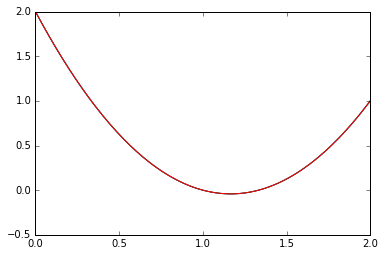

In [23]:
gfuei = [gfue(xip) for xip in xi]

plt.plot(xi,ui)
plt.plot(xi,gfuei)
plt.plot(xi,uexact(xi))